In [1]:
# 定义保存数据的类
import numpy as np

#定义类
class IPAccessData(object):
    def __init__(self, X, y, coverage):
        self.X = X
        self.y = y
        self.coverage = coverage
#         self.ip_dict = ip_dict
#         self.ip_reserve_list = ip_reserve_list
#         self.data_scaler = data_scaler


In [2]:
# time_window = 240
n_behavior = 10
time_steps = 20
dimension = 32
n_class = 2

In [3]:
import pickle
fp = open('iPAccessData_behavior.pkl','rb',True)
iPAccessData = pickle.load(fp)
# X = iPAccessData.X
# labels = iPAccessData.y

In [4]:
# test_idx = np.argmax(train_y,axis=1)
# (labels==1).sum()

In [5]:
iPAccessData.X.shape

(6982, 10, 20, 32)

In [26]:
#截取一部分数据（因为正常数据太多了）
X0 = iPAccessData.X[iPAccessData.y==0,:,:]
random_select = np.random.choice(X0.shape[0], 200) #随即选择200个数据
# X0 = X0[random_select]

X1 = iPAccessData.X[iPAccessData.y==1,:,:]

X2 = iPAccessData.X[iPAccessData.y==2,:,:]
random_select = np.random.choice(X2.shape[0], 200) #随即选择200个数据
# X2 = X2[random_select]


X = np.concatenate((X0, X1, X2), axis=0) #与异常标签数据合并
labels = np.concatenate((np.zeros(X0.shape[0]), np.ones(X1.shape[0]), np.zeros(X2.shape[0])) , axis=0) #与异常标签数据合并
print (X.shape)
print (labels.shape)

(6982, 10, 20, 32)
(6982,)


In [31]:
import keras

y = keras.utils.to_categorical(labels, num_classes=n_class)

print(X.shape)
print(labels.shape)
print(y.shape)

(6982, 10, 20, 32)
(6982,)
(6982, 2)


In [32]:
from sklearn.model_selection import train_test_split
X = X.reshape([-1,n_behavior*time_steps*dimension])

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.5, random_state=888)
test_X, val_X, test_y, val_y = train_test_split(test_X, test_y, test_size=0.5, random_state=888)

train_X = train_X.reshape([-1,n_behavior,time_steps,dimension])
test_X = test_X.reshape([-1,n_behavior,time_steps,dimension])
val_X = val_X.reshape([-1,n_behavior,time_steps,dimension])
print (train_X.shape, test_X.shape, val_X.shape)

(3491, 10, 20, 32) (1745, 10, 20, 32) (1746, 10, 20, 32)


In [33]:
from keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Dropout
from keras.models import Model

x0 = Input(shape=(time_steps, dimension), dtype='float32', name='input0')
x1 = Input(shape=(time_steps, dimension), dtype='float32', name='input1')
x2 = Input(shape=(time_steps, dimension), dtype='float32', name='input2')
x3 = Input(shape=(time_steps, dimension), dtype='float32', name='input3')
x4 = Input(shape=(time_steps, dimension), dtype='float32', name='input4')
x5 = Input(shape=(time_steps, dimension), dtype='float32', name='input5')

operation_lstm = LSTM(64, input_shape=(time_steps, dimension))

behavior0 = operation_lstm(x0)
behavior1 = operation_lstm(x1)
behavior2 = operation_lstm(x2)
behavior3 = operation_lstm(x3)
behavior4 = operation_lstm(x4)

behaviors = keras.layers.concatenate([behavior0, behavior1, behavior2, behavior3, behavior4])
print (behaviors.shape)
behaviors = keras.layers.core.Reshape((5,64))(behaviors)

behavior_lstm = LSTM(64, input_shape = (5,64))
print (behaviors.shape)
x = behavior_lstm(behaviors)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(n_class, activation='softmax')(x)


model = Model(inputs=[x0,x1,x2,x3,x4], outputs=predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = model.fit([train_X[:,0,:,:],train_X[:,1,:,:], train_X[:,2,:,:],train_X[:,3,:,:],train_X[:,4,:,:]],
          train_y, batch_size=64, epochs=100,
          validation_data=([val_X[:,0,:,:],val_X[:,1,:,:],val_X[:,2,:,:],val_X[:,3,:,:],val_X[:,4,:,:]],
                           val_y))
# score = model.evaluate(x_test, y_test, batch_size=16)

(?, 320)
(?, 5, 64)
Train on 3491 samples, validate on 1746 samples
Epoch 1/100
3491/3491 [==============================] - 9s - loss: 0.2587 - acc: 0.9313 - val_loss: 0.1398 - val_acc: 0.9559
Epoch 2/100
3491/3491 [==============================] - 6s - loss: 0.1390 - acc: 0.9608 - val_loss: 0.1133 - val_acc: 0.9639
Epoch 3/100
3491/3491 [==============================] - 6s - loss: 0.1164 - acc: 0.9648 - val_loss: 0.0940 - val_acc: 0.9651
Epoch 4/100
3491/3491 [==============================] - 6s - loss: 0.1026 - acc: 0.9651 - val_loss: 0.0994 - val_acc: 0.9685
Epoch 5/100
3491/3491 [==============================] - 6s - loss: 0.1028 - acc: 0.9671 - val_loss: 0.0930 - val_acc: 0.9679
Epoch 6/100
3491/3491 [==============================] - 6s - loss: 0.0954 - acc: 0.9685 - val_loss: 0.0908 - val_acc: 0.9691
Epoch 7/100
3491/3491 [==============================] - 6s - loss: 0.0885 - acc: 0.9691 - val_loss: 0.0913 - val_acc: 0.9714
Epoch 8/100
3491/3491 [===========================

3491/3491 [==============================] - 6s - loss: 0.0490 - acc: 0.9802 - val_loss: 0.1135 - val_acc: 0.9754
Epoch 66/100
3491/3491 [==============================] - 6s - loss: 0.0517 - acc: 0.9794 - val_loss: 0.1179 - val_acc: 0.9748
Epoch 67/100
3491/3491 [==============================] - 6s - loss: 0.0539 - acc: 0.9777 - val_loss: 0.0803 - val_acc: 0.9782
Epoch 68/100
3491/3491 [==============================] - 6s - loss: 0.0517 - acc: 0.9782 - val_loss: 0.0840 - val_acc: 0.9771
Epoch 69/100
3491/3491 [==============================] - 6s - loss: 0.0518 - acc: 0.9782 - val_loss: 0.0776 - val_acc: 0.9771
Epoch 70/100
3491/3491 [==============================] - 6s - loss: 0.0503 - acc: 0.9791 - val_loss: 0.0740 - val_acc: 0.9794
Epoch 71/100
3491/3491 [==============================] - 6s - loss: 0.0570 - acc: 0.9771 - val_loss: 0.0850 - val_acc: 0.9782
Epoch 72/100
3491/3491 [==============================] - 6s - loss: 0.0476 - acc: 0.9794 - val_loss: 0.0984 - val_acc: 0.97

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


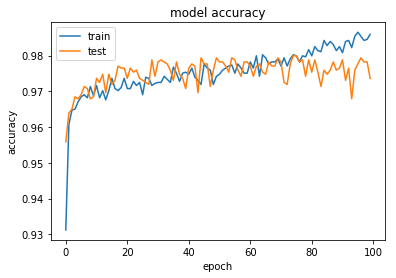

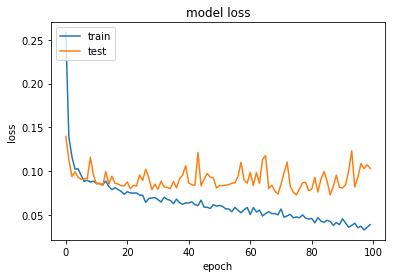

In [36]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [37]:
#每一个类别，进行识别率和F1-score验证
pred_y = model.predict([test_X[:,0,:,:],test_X[:,1,:,:],test_X[:,2,:,:],test_X[:,3,:,:],test_X[:,4,:,:]], batch_size=32, verbose=0)

pred_idx = np.argmax(pred_y,axis=1)
test_idx = np.argmax(test_y,axis=1)

In [38]:
# #每一个类别，进行识别率和F1-score验证
# pred_y = model.predict([X[:,0,:,:],X[:,1,:,:],X[:,2,:,:],X[:,3,:,:],X[:,4,:,:]], batch_size=32, verbose=0)

# pred_idx = np.argmax(pred_y,axis=1)
# labels[labels==2] = 0

In [39]:
labels.shape

(6982,)

In [41]:
from sklearn.metrics import classification_report

print (classification_report(test_idx, pred_idx))
# print (test_generator.class_indices)

             precision    recall  f1-score   support

          0       0.99      0.98      0.98      1646
          1       0.67      0.77      0.72        99

avg / total       0.97      0.97      0.97      1745



In [233]:
false_negative = (pred_idx==0) & (test_idx==1) #被认为是正常，但是实际上是异常
false_positive = (pred_idx==1) & (test_idx==0) #被认为是异常，但是实际上正常

In [ ]:
#给定一组数据，返回这个数据在原始数据中的index，可以直接用iPAccessData.成员【index】来查看的
def find_data_position(samples):
    indexes = list()
    for x in samples:
        a = (np.abs(iPAccessData.X-x).sum(axis=3).sum(axis=2).sum(axis=1)<0.00001)
        indexes.append([np.where(a==1)[0],])
    return indexes

In [ ]:
b = np.where(false_positive==1)#查一下test里面那些是错误分类的
b

In [ ]:
a = find_data_position(test_X[false_positive]) #注意如果是单个数据，一定要把这个数据在包装一层数组
a

In [ ]:
#在总数据里面的idx，在test里面的idx，预测的概率
for i in range(len(a)):
    print (a[i][0], b[0][i], pred_y[b[0][i]])

In [50]:
#读取之前的url_list数据，配合假阴性假阳性判断
class IPAccessInfo(object):
    def __init__(self, all_url_list, all_url_dict_list):
        self.all_url_list = all_url_list
        self.all_url_dict_list = all_url_dict_list
        
import pickle
fp = open('url_info.pkl','rb',True)
iPAccessInfo = pickle.load(fp)

In [94]:
false_negative_urls = [iPAccessInfo.all_url_list[i] for i,v in enumerate(false_negative) if v==True]
false_negative_urls  #被认为是正常，但是实际上是异常的，看看对不对吧

NameError: name 'iPAccessInfo' is not defined

In [52]:
false_positive_urls = [iPAccessInfo.all_url_list[i] for i,v in enumerate(false_positive) if v==True]
false_positive_urls  #被认为是异常，但是实际上是正常的，看看对不对吧

[['POST /.../getDept.do',
  'GET common/.../scheduleByDept.do',
  'POST /.../scheduleByDept.do',
  'GET common/.../arrangementList.do',
  'GET common/.../arrangementList.do',
  'POST /.../getTimeList.do',
  'GET common/.../reserveConfirm.do',
  'POST /.../reserveConfirm.do',
  'GET common/.../patientList.do',
  'GET /.../patientinfo.do',
  'GET common/.../reserveConfirm.do',
  'POST /.../reserveConfirm.do',
  'POST /.../reserve.do'],
 ['GET common/.../arrangementList.do',
  'POST /.../getTimeList.do',
  'GET common/.../reserveConfirm.do',
  'POST /.../reserveConfirm.do'],
 ['GET common/.../arrangementList.do',
  'GET common/.../arrangementList.do',
  'GET common/.../login.do',
  'POST /.../scheduleByDept.do',
  'POST /.../getDept.do',
  'GET common/.../chooseExpert.do',
  'GET common/.../deptList.do',
  'POST /.../getDept.do',
  'GET common/.../scheduleByDept.do',
  'POST /.../scheduleByDept.do'],
 ['GET common/.../scheduleByDept.do',
  'POST /.../scheduleByDept.do',
  'POST /.../getDe

In [139]:


# 单层LSTM模型的输入是（？，timestep，32）
# 双层模型是（？，5，timestep，32）
# 步骤
# 1. 先把双层模型数据中5压平，相当于数据个数扩充5倍，变为 （？*5， timestep， 32）
# 2. 读取训练好的单层模型，将双层模型数据转化为（？*5，32），其中最后一个维度是单层lstm模型中倒数第二个dense的神经元个数=32
# 3. 把数据还原为(?,5,32),用另一个单层LSTM学习
# 4. 注意，所有的数据，在url向量化的时候必须是统一的，保存在url_embedding.pkl中，变量是url_dict



# intermediate_output = intermediate_layer_model.predict(test_X)

In [140]:
# step1
X2 = X.reshape([-1,time_steps,dimension])
X2.shape

(4720, 20, 32)

In [141]:
#step 2
from keras.models import load_model

single_lstm_model = load_model('single_layer_lstm.h5')

from keras.models import Model
intermediate_layer_model = Model(inputs=single_lstm_model.input,
                                 outputs=single_lstm_model.get_layer('dense1').output)

X2 = intermediate_layer_model.predict(X2)
X2.shape

(4720, 32)

In [142]:
# step3
X2 = X2.reshape([-1,n_behavior,dimension])
X = X2 #覆盖之前的X！！！！！
print (X.shape)
print (y.shape)

(472, 10, 32)
(472, 2)


In [143]:
from sklearn.model_selection import train_test_split
X = X.reshape([-1,n_behavior*dimension])
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.50, random_state=888)

test_X, val_X, test_y, val_y = train_test_split(test_X, test_y, test_size=0.5, random_state=888)

train_X = train_X.reshape([-1,n_behavior,dimension])
test_X = test_X.reshape([-1,n_behavior,dimension])
val_X = val_X.reshape([-1,n_behavior,dimension])
print (train_X.shape, test_X.shape, val_X.shape)

(236, 10, 32) (118, 10, 32) (118, 10, 32)


In [144]:
# 定义神经网络
# 原始数据--向量LSTM（64）--全连接Dense（64）--全连接Dense（2）

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM

# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential()
model.add(LSTM(64, input_shape=(n_behavior, dimension),name='lstm_layer'))  # returns a sequence of vectors of dimension 32
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu',name='dense1'))
model.add(Dropout(0.5))
model.add(Dense(n_class, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = model.fit(train_X, train_y, batch_size=64, epochs=10,validation_data=(val_X, val_y))
# score = model.evaluate(x_test, y_test, batch_size=16)

Train on 236 samples, validate on 118 samples
Epoch 1/10
236/236 [==============================] - 4s - loss: 0.5291 - acc: 0.7076 - val_loss: 0.3272 - val_acc: 0.8814
Epoch 2/10
236/236 [==============================] - 0s - loss: 0.3993 - acc: 0.8475 - val_loss: 0.3049 - val_acc: 0.8814
Epoch 3/10
236/236 [==============================] - 0s - loss: 0.3760 - acc: 0.8898 - val_loss: 0.2937 - val_acc: 0.8814
Epoch 4/10
236/236 [==============================] - 0s - loss: 0.3308 - acc: 0.8856 - val_loss: 0.2858 - val_acc: 0.8814
Epoch 5/10
236/236 [==============================] - 0s - loss: 0.3137 - acc: 0.8814 - val_loss: 0.2793 - val_acc: 0.8814
Epoch 6/10
236/236 [==============================] - 0s - loss: 0.3150 - acc: 0.8941 - val_loss: 0.2742 - val_acc: 0.8814
Epoch 7/10
236/236 [==============================] - 0s - loss: 0.2949 - acc: 0.8941 - val_loss: 0.2641 - val_acc: 0.8814
Epoch 8/10
236/236 [==============================] - 0s - loss: 0.3183 - acc: 0.8898 - val_l

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


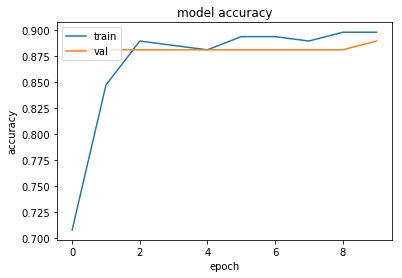

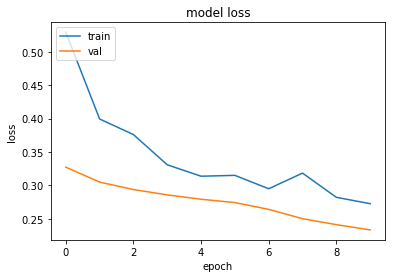

In [145]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [148]:
#每一个类别，进行识别率和F1-score验证
pred_y = model.predict(test_X, batch_size=32, verbose=0)

pred_idx = np.argmax(pred_y,axis=1)
test_idx = np.argmax(test_y,axis=1)

In [149]:
from sklearn.metrics import classification_report

print (classification_report(test_idx, pred_idx))
# print (test_generator.class_indices)

             precision    recall  f1-score   support

          0       0.85      1.00      0.92        95
          1       1.00      0.26      0.41        23

avg / total       0.88      0.86      0.82       118

